## Import of python librairies
    We start by importing all the librairies necessary for ourn work.
    * Pandas : with this library we will be able to import our data in the form of a multidimensional table and thus 
    handle them more easily.
    * Matplotlib : it will allow us to draw the diagrams that will facilitate the analysis of our data.
    * Scikit-learn : this library contains the implementation of the model we will use for classification.
    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB


## Plan of work

We will work according to the data scientist cycle. Although the one we will propose is 
by no means absolute, because it varies a lot according to the documentation and opinions, 
but we have decided on this one, for its simplicity 

    1. Data Collection
    2. Data Cleaning
    3. Data Mining (Data Exploration)
    4. Training
    5. Evaluation & Interpretation
    6. Production (Testing) 



## I. Data Collection 
* for this simple step we will just retrieve the file that contains our data and store 
the information in a variable using the pandas library.
        by default the information is separated in a csv file by a ','
        in our case it is one ';' then we must mention this when importing
        
* We will also display a few lines in a table to make sure that the import went well.


In [2]:
# import file into a variable
data_set = pd.read_csv('transaction_training_set.csv', sep=';')

#we can see the appearance of the unnamed column that was automatically added, 
# when the file was imported. We will delete the column from our data_set
column_to_drop = ['Unnamed: 0']
data_set.drop(column_to_drop, inplace=True, axis=1)

# display teh 5 first line of our set
data_set.head()



,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure


* In order to properly test our model, it would be nice to divide our dataset into 2 parts, 
one for model training and another part to evaluate the model and see its accuracy.


In [3]:
# split the data_set into 2 sets (training_set and evaluation_set)
labels = data_set['label'].copy()
data_set_without_label = data_set.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data_set_without_label, labels, test_size=0.3, shuffle=True)



## II. Data cleaning
Cleaning up data is about making sure it is consistent, without outliers or missing values.

* one of the tasks we can do here is to convert the data type of the Betrag column into a numerical type in order to 
facilitate the different calculations that could be done when studying this variable.


In [ ]:
serie = pd.Series(data_set["Betrag"])
index = 0
for row in serie:
    tmp = row.replace(',', '.')
    serie[index] = float(tmp)
    index += 1
    

## III. Data Exploration

The quality of our input data determines the quality of our output result.

### 1. Feature Engineering

####  a) Feature Selection

*  the "Auftragskonto" column only tells us where the different financial transactions come from and not the type of transaction itself. 
    We therefore find this column not very useful for the analysis of our data and the choice of model
    
* The 2 columns "Buchungstag" and "Valutadatum" have almost the same values except for a few cases where they are different.
    For this reason we will delete the column "Valutadatum", because otherwise we will have almost a duplicate of information.
    
* 'Kontonummer', 'BLZ', 'Waehrung' do not provide important information for the classification of financial transactions 
    and will therefore also be deleted


In [4]:
to_drop = ['Auftragskonto', 'Valutadatum', 'Kontonummer', 'BLZ', 'Waehrung']
data_set.drop(to_drop, inplace=True, axis=1)

# let's see what our data currently looks like
data_set.head()



,Buchungstag,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Betrag,label
0,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,2000.00,income
1,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,-670.00,living
2,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,-70.00,private
3,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,-73.21,standardOfLiving
4,18.07.2016,Spontanausgabe,Amazon,neue Playstation,-363,leisure


##### b) Feature Extraction
* In the date only the day and month have a certain importance, the year on the other hand does not provide us any information on the nature of the transaction.
The day on the other hand can inform us about the type of transaction, indeed it is rather logical to have at the end of the month transactions such as rent or salary.



### 2. Exploration Data Analysis
Below are the steps involved to understand, and prepare our data for building our predictive model.
    
    a. Variable Identification
    b. Univariate Analysis
    c. Bi-variate Analysis
    d. Missing values treatment
    e. Outlier treatment
   
##### a. Variable Identification

* Type of variable

> 1- Predictor Variable
- Buchungstext
- verwendungszweck
- Beguenstigter/Zahlungspflichtiger
- Betrag

> 2- Target variable
- label


* Data Type

> 1- Character
- Buchungstext
- Verwendungszweck
- Beguenstigter/Zahlungspflichtiger
- label

> 2- Numeric
- Betrag



##### b. Univariate Analysis
* This part will allow us to explore the variables one by one. The analysis method we will use will depend 
on the nature of our variable (if it is a continuous variable for example).

* For categorical variables (Buchungstext, Verwendungszweck, Beguenstigter/Zahlungspflichtiger) , we’ll use frequency table to understand distribution of each category. We can also read as percentage of values under each category.
Bar chart or pie chart can be used as visualization.



* let's also analyze the frequency of the values of the variable "Beguenstigter/Zahlungspflichtiger".


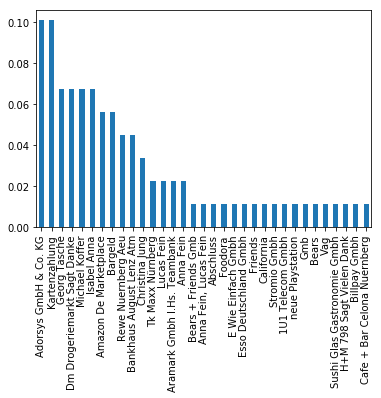

In [5]:
# variable Beguenstigter/Zahlungspflichtiger
data_set['Beguenstigter/Zahlungspflichtiger'].value_counts(normalize=True).plot(kind='bar')
plt.title("Distribution of variable Beguenstigter/Zahlungspflichtiger")
plt.show()



* frequency table for the variable "Buchungstext".


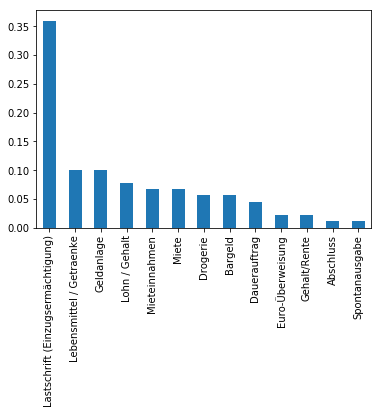

In [6]:
# bar chart for variable Buchungstext
data_set['Buchungstext'].value_counts(normalize=True).plot(kind='bar', width=0.5)
plt.title("Distribution of variable Buchungstext")
plt.show()
        


#### c. Bi-variate Analysis
* the notion of the relationship between variables is called correlation. To say that two variables are correlated means 
that if we know the value of one variable, then it is possible to have an indication (more or less precise) 
on the value of another variable.
* Here, we look for association and disassociation between variables at a pre-defined significance level. 
We can perform bi-variate analysis for any combination of categorical and continuous variables.

> 2 Continuous  variable --> scatterplot

> 2 Categorical variable -->  Two-way table, Chi-2

> 1 Categorical and 1 Continuous --> ANOVA


let's look at a correlation between the variables "Buchungstext" and "label".

* Analyse : As we can see on the diagram, with the exception of "Lastschrift (Einzugsermächtigung)", each value of the variable 
"Buchungstext" is assigned to a single label value showing a correlation between the 2 variables.


In [ ]:
Y = "label"
X = "Buchungstext"

c = data_set[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()

tx = data_set[X].value_counts()
ty = data_set[Y].value_counts()

tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)
tx.columns = ["foo"]
ty.columns = ["foo"]
n = len(data_set)
indep = tx.dot(ty.T) / n


c = c.fillna(0) # we replace the null values by 0
mesure = (c - indep)**2 / indep
xi_n = mesure.sum().sum()
sns.heatmap(mesure/xi_n,annot=c)
plt.show()


look for a correlation between the variable "Beguenstigter/Zahlungspflichtiger" and "label"

* Analyse : The rows represents the category of "Beguenstigter/Zahlungspflichtiger" and the columns 
represent the categories of the other variable("label"). 
Here too, it can be seen that the presence or absence of a value of the variable can almost reflect the belonging to a very specific category.


In [ ]:
Y = "label"
X = "Beguenstigter/Zahlungspflichtiger"

c = data_set[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()

tx = data_set[X].value_counts()
ty = data_set[Y].value_counts()

cont.loc[:,"Total"] = tx
cont.loc["total",:] = ty
cont.loc["total","Total"] = len(data_set)
cont


look for a correlation between the variable "Beguenstigter/Zahlungspflichtiger" and "Buchungstext"

* Analyse : the table below already confirms the trend observed in the 2 previous analyses. 
Indeed, if we take for example "Adorsys GmbH & Co. KG" which is a value of the variable "Beguenstigter/Zahlungspflichtiger", 
we can notice that it appears in data having for Buchungstext "Gehalt/Rente" and "Lohn / Gehalt". 
these 2 values of the variable Buchungstext are also significant for belonging to the category "income".
In the previous analysis, we also noted that the term "Adorsys GmbH & Co. KG" of the variable could be an indicator of the category "income".


In [ ]:
Y = "Buchungstext"
X = "Beguenstigter/Zahlungspflichtiger"

c = data_set[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()

tx = data_set[X].value_counts()
ty = data_set[Y].value_counts()

cont.loc[:,"Total"] = tx
cont.loc["total",:] = ty
cont.loc["total","Total"] = len(data_set)
cont


look for a correlation between the variable "Verwendungszweck" and "Buchungstext"

* Analyse : this table shows us that an adequate transformation of variable "Verwendungszweck" 
could also be an indicator of category membership, or could also help when the values present in 
"Beguenstigter/Zahlungspflichtiger" and "Buchungstext" would not be sufficient for the categorization of a financial transaction.


In [ ]:
Y = "Buchungstext"
X = "Verwendungszweck"

c = data_set[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
cont = c.copy()

tx = data_set[X].value_counts()
ty = data_set[Y].value_counts()

cont.loc[:,"Total"] = tx
cont.loc["total",:] = ty
cont.loc["total","Total"] = len(data_set)
cont


#### d. Missing values treatment
* The absence of some data in our dataset may reduce the accuracy of our model or may lead to a biased model 
because we have not properly analyzed the behaviour and relationship with the other variables. 
This can lead to prediction or misclassification.

* In the case of a training data set, the proportion of missing data is almost non-existent, so we won't do anything about it.


#### e. Outlier treatment

* An outlier can be a value that is clearly false or a value that "stands out from the crowd", but not necessarily false.



## IV. Training